In [ ]:
!pip install langchain-groq langgraph chromadb langchain-huggingface langchain-community pypdf langchain_chroma sentence-transformers

In [4]:
from google.colab import userdata
import os

GROQ_API_KEY = userdata.get('GROQ_API_KEY')
os.environ['GROQ_API_KEY'] = GROQ_API_KEY

In [5]:
from langchain_groq import ChatGroq
llm = ChatGroq(
    model_name="llama-3.3-70b-versatile",
    temperature=0.1,
    max_tokens=1024
)

In [6]:
from langchain_huggingface import HuggingFaceEmbeddings
embeddings = HuggingFaceEmbeddings(
    model_name="sentence-transformers/all-MiniLM-L6-v2"
)

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:104: UserWarning: 
Error while fetching `HF_TOKEN` secret value from your vault: 'Requesting secret HF_TOKEN timed out. Secrets can only be fetched when running from the Colab UI.'.
You are not authenticated with the Hugging Face Hub in this notebook.
If the error persists, please let us know by opening an issue on GitHub (https://github.com/huggingface/huggingface_hub/issues/new).
  warnings.warn(


modules.json:   0%|          | 0.00/349 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/116 [00:00<?, ?B/s]

README.md: 0.00B [00:00, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/612 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/90.9M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/350 [00:00<?, ?B/s]

vocab.txt: 0.00B [00:00, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/190 [00:00<?, ?B/s]

In [7]:
import tempfile

persist_directory = tempfile.mkdtemp()

In [10]:
from langchain_community.document_loaders import PyPDFLoader
from langchain.text_splitter import RecursiveCharacterTextSplitter
from langchain_chroma import Chroma

def load_and_process_pdf(pdf_path="sample.pdf"):
    """Load PDF and create vector store"""

    # Load PDF
    loader = PyPDFLoader(pdf_path)
    documents = loader.load()

    # Split documents
    text_splitter = RecursiveCharacterTextSplitter(
        chunk_size=1000,
        chunk_overlap=200
    )
    splits = text_splitter.split_documents(documents)

    # Create vector store
    vectorstore = Chroma.from_documents(
        documents=splits,
        embedding=embeddings,
        persist_directory=persist_directory
    )

    return vectorstore

vectorstore = load_and_process_pdf("/content/attention-is-all-you-need.pdf")

In [11]:
from typing import TypedDict, List

class RAGState(TypedDict):
    question: str
    retrieved_docs: List[str]
    answer: str
    conversation_history: List[dict]
    sources: List[str]

In [12]:
conversation_memory = []

In [13]:
def retrieve_documents(state: RAGState) -> RAGState:
    """Retrieve relevant documents from vector store"""
    question = state["question"]

    docs = vectorstore.similarity_search(question, k=3)

    retrieved_texts = [doc.page_content for doc in docs]
    sources = [f"Page {doc.metadata.get('page', 'Unknown')}" for doc in docs]

    state["retrieved_docs"] = retrieved_texts
    state["sources"] = sources

    return state

In [14]:
def generate_answer(state: RAGState) -> RAGState:
    """Generate answer using retrieved documents and conversation history"""
    question = state["question"]
    retrieved_docs = state["retrieved_docs"]
    history = state.get("conversation_history", [])

    context = "\n\n".join(retrieved_docs)

    history_context = ""
    if history:
        history_context = "\n".join([
            f"Previous Q: {item['question']}\nPrevious A: {item['answer']}"
            for item in history[-3:]  # Keep last 3 exchanges
        ])

    prompt = f"""
    Based on the following context and previous conversation, answer the question accurately and concisely.

    Previous Conversation:
    {history_context}

    Current Context:
    {context}

    Current Question: {question}

    Answer:
    """

    response = llm.invoke(prompt)
    answer = response.content

    state["answer"] = answer

    return state

In [15]:
def update_memory(state: RAGState) -> RAGState:
    """Update conversation memory"""
    global conversation_memory

    conversation_memory.append({
        "question": state["question"],
        "answer": state["answer"],
        "sources": state["sources"]
    })

    if len(conversation_memory) > 10:
        conversation_memory = conversation_memory[-10:]

    state["conversation_history"] = conversation_memory

    return state

In [16]:
from langgraph.graph import StateGraph, END

workflow = StateGraph(RAGState)

workflow.add_node("retrieve", retrieve_documents)
workflow.add_node("generate", generate_answer)
workflow.add_node("memory", update_memory)

workflow.set_entry_point("retrieve")
workflow.add_edge("retrieve", "generate")
workflow.add_edge("generate", "memory")
workflow.add_edge("memory", END)

app = workflow.compile()

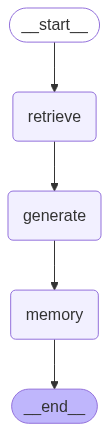

In [17]:
app

In [18]:
def ask_question(question: str):
    """Ask a question to the RAG agent"""

    # Initial state
    initial_state = {
        "question": question,
        "retrieved_docs": [],
        "answer": "",
        "conversation_history": conversation_memory,
        "sources": []
    }

    result = app.invoke(initial_state)

    print(f"\n🤖 Question: {question}")
    print(f"\n📝 Answer: {result['answer']}")
    print(f"\n📚 Sources: {', '.join(result['sources'])}")
    print("\n" + "="*50)

    return result

ask_question("What is the main topic of this document?")


🤖 Question: What is the main topic of this document?

📝 Answer: The main topic of this document appears to be a research paper discussing the use of self-attention mechanisms in neural network models, specifically in the context of machine translation, as part of the tensorflow/tensor2tensor project.

📚 Sources: Page 8, Page 9, Page 6



{'question': 'What is the main topic of this document?',
 'retrieved_docs': ['tensorflow/tensor2tensor.\nAcknowledgements W e are grateful to Nal Kalchbrenner and Stephan Gouws for their fruitful\ncomments, corrections and inspiration.\n9',
  '2017.\n[16] Y oon Kim, Carl Denton, Luong Hoang, and Alexander M. Rush. Structured attention networks.\nIn International Conference on Learning Representations, 2017.\n[17] Diederik Kingma and Jimmy Ba. Adam: A method for stochastic optimization. In ICLR, 2015.\n[18] Oleksii Kuchaiev and Boris Ginsburg. Factorization tricks for LSTM networks. arXiv preprint\narXiv:1703.10722, 2017.\n[19] Zhouhan Lin, Minwei Feng, Cicero Nogueira dos Santos, Mo Y u, Bing Xiang, Bowen\nZhou, and Y oshua Bengio. A structured self-attentive sentence embedding. arXiv preprint\narXiv:1703.03130, 2017.\n[20] Samy Bengio Łukasz Kaiser. Can active memory replace attention? In Advances in Neural\nInformation Processing Systems, (NIPS), 2016.\n10',
  'convolution is equal t

In [19]:
ask_question("What is Self Attention?")


🤖 Question: What is Self Attention?

📝 Answer: Self-attention is an attention mechanism that relates different positions of a single sequence to compute a representation of the sequence. It allows the model to consider the relationships between different parts of the input sequence simultaneously and weigh their importance, rather than processing the sequence sequentially.

📚 Sources: Page 1, Page 5, Page 5



{'question': 'What is Self Attention?',
 'retrieved_docs': ['described in section 3.2.\nSelf-attention, sometimes called intra-attention is an attention mechanism relating different positions\nof a single sequence in order to compute a representation of the sequence. Self-attention has been\nused successfully in a variety of tasks including reading comprehension, abstractive summarization,\ntextual entailment and learning task-independent sentence representations [4, 22, 23, 19].\nEnd-to-end memory networks are based on a recurrent attention mechanism instead of sequence-\naligned recurrence and have been shown to perform well on simple-language question answering and\nlanguage modeling tasks [28].\nT o the best of our knowledge, however, the Transformer is the ﬁrst transduction model relying\nentirely on self-attention to compute representations of its input and output without using sequence-\naligned RNNs or convolution. In the following sections, we will describe the Transformer, mo

In [20]:
ask_question("Can you provide more details about that?")


🤖 Question: Can you provide more details about that?

📝 Answer: It seems like you're asking for more details about the Transformer model, specifically in the context of machine translation. The Transformer model is a type of neural network architecture that uses self-attention mechanisms to relate different positions of a single sequence, allowing it to consider relationships between different parts of the input sequence simultaneously.

The Transformer model has several key components, including the use of convolutional neural networks as basic building blocks, computing hidden representations in parallel for all input and output positions. However, this approach can make it more difficult to learn dependencies between distant positions.

To address this issue, the Transformer model uses Multi-Head Attention, which allows it to jointly attend to information from different representation subspaces at different positions. This is described in more detail in section 3.2 of the document.

{'question': 'Can you provide more details about that?',
 'retrieved_docs': ['The goal of reducing sequential computation also forms the foundation of the Extended Neural GPU\n[20], ByteNet [ 15] and ConvS2S [ 8], all of which use convolutional neural networks as basic building\nblock, computing hidden representations in parallel for all input and output positions. In these models,\nthe number of operations required to relate signals from two arbitrary input or output positions grows\nin the distance between positions, linearly for ConvS2S and logarithmically for ByteNet. This makes\nit more difﬁcult to learn dependencies between distant positions [ 11]. In the Transformer this is\nreduced to a constant number of operations, albeit at the cost of reduced effective resolution due\nto averaging attention-weighted positions, an effect we counteract with Multi-Head Attention as\ndescribed in section 3.2.\nSelf-attention, sometimes called intra-attention is an attention mechanism relating d

In [21]:
def show_conversation_history():
    """Display the conversation history"""
    print("\n📋 Conversation History:")
    for i, conv in enumerate(conversation_memory, 1):
        print(f"\n{i}. Q: {conv['question']}")
        print(f"   A: {conv['answer'][:100]}...")
        print(f"   Sources: {', '.join(conv['sources'])}")

show_conversation_history()


📋 Conversation History:

1. Q: What is the main topic of this document?
   A: The main topic of this document appears to be a research paper discussing the use of self-attention ...
   Sources: Page 8, Page 9, Page 6

2. Q: What is Self Attention?
   A: Self-attention is an attention mechanism that relates different positions of a single sequence to co...
   Sources: Page 1, Page 5, Page 5

3. Q: Can you provide more details about that?
   A: It seems like you're asking for more details about the Transformer model, specifically in the contex...
   Sources: Page 1, Page 7, Page 7
